<a href="https://colab.research.google.com/github/jaimedecarlos/MPC-discretization-analysis-through-different-Runge-Kutta-methods/blob/main/MPC_discretization_analysis_through_different_Runge_Kutta_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPC discretization analysis

***

Copyright (c) 2026 Jaime de Carlos de Churruca

Permission is hereby granted, free of charge, to any person obtaining a copy of this
software and associated documentation files (the “Software”), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software, subject to the
following conditions:

The above copyright notice and this permission notice shall be included in all copies
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED.

***

In [1]:
# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install polytope

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

***

In [2]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.pyplot as plt

#====== Solving constrained finite-time optimal control (CFTOC) problem ======
def solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af):
  nx = np.shape(A)[1]
  nu = np.shape(B)[1]

  model = pyo.ConcreteModel()
  model.txidx = pyo.Set(initialize=range(0, N+1))
  model.tuidx = pyo.Set(initialize=range(0, N))
  model.xidx = pyo.Set(initialize=range(0, nx))
  model.uidx = pyo.Set(initialize=range(0, nu))
  model.k_terminal = pyo.Set(initialize=range(Af.shape[0]))

  model.x = pyo.Var(model.xidx, model.txidx)
  model.u = pyo.Var(model.uidx, model.tuidx)

  model.cost = pyo.Objective(
      expr = sum(P[i, j] * model.x[i, N] * model.x[j, N] for i in model.xidx for j in model.xidx) +
      sum(sum(Q[i, j] * model.x[i, t] * model.x[j, t] for i in model.xidx for j in model.xidx) for t in model.txidx if t < N) +
      sum(sum(R[i, j] * model.u[i, t] * model.u[j, t] for i in model.uidx for j in model.uidx) for t in model.tuidx if t < N),
      sense=pyo.minimize
  )

  def x_dyn_constraint_rule(model, i, t):
      return model.x[i, t+1] == sum(A[i,j]*model.x[j,t] for j in model.xidx) + sum(B[i,j]*model.u[j,t] for j in model.uidx)

  model.x_dyn_constraint = pyo.Constraint(model.xidx, model.tuidx, rule=x_dyn_constraint_rule)

  def x_upper_bound_rule(model, i, t):
    return model.x[i, t] <= xU

  def x_lower_bound_rule(model, i, t):
    return model.x[i, t] >= xL

  def u_upper_bound_rule(model, i, t):
    return model.u[i, t] <= uU

  def u_lower_bound_rule(model, i, t):
    return model.u[i, t] >= uL

  model.x_upper_bound = pyo.Constraint(model.xidx, model.tuidx, rule=x_upper_bound_rule)
  model.x_lower_bound = pyo.Constraint(model.xidx, model.tuidx, rule=x_lower_bound_rule)
  model.u_upper_bound = pyo.Constraint(model.uidx, model.tuidx, rule=u_upper_bound_rule)
  model.u_lower_bound = pyo.Constraint(model.uidx, model.tuidx, rule=u_lower_bound_rule)

  def x_initial_rule(model, i):
    return model.x[i, 0] == x0[i]

  model.x_initial = pyo.Constraint(model.xidx, rule=x_initial_rule)

  if np.array_equal(Af,np.array([])): #or (isinstance(Af, list) and not Af) or (isinstance(Af, np.ndarray) and Af.size == 0):
      # Terminal set is a single point x_N == bf
      def x_final_point_rule(model, i):
          return model.x[i, N] == bf[i]
      model.x_final_point = pyo.Constraint(model.k_terminal, rule=x_final_point_rule)
  else:
      # Terminal set is Af x_N <= bf
      def x_final_set_rule(model, k):
          return sum(Af[k, j] * model.x[j, N] for j in model.xidx) <= bf[k]
      model.x_final_set = pyo.Constraint(model.k_terminal, rule=x_final_set_rule)

  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model, tee=False) # tee=True can show solver output
  print("Asked by perp: ",results.solver.status, results.solver.termination_condition)
  xOpt = np.zeros([nx, N+1])
  uOpt = np.zeros([nu, N])
  JOpt = 0.0

  for t in model.txidx:
    for i in model.xidx:
      xOpt[i, t] = pyo.value(model.x[i, t])
    if t < N:
      for i in model.uidx:
        uOpt[i, t] = pyo.value(model.u[i, t])
  JOpt = pyo.value(model.cost)

  if results.solver.termination_condition == TerminationCondition.infeasible:
    feas = False
  else:
    feas = True

  return [feas, xOpt, uOpt, JOpt]

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


Asked by perp:  warning infeasible
time = 0.0736854870000343
feas = False
JOpt = 435.554759286778
xOpt =
 [[ 9.70542817e-01  9.70542817e-01  9.13219003e-01  7.98571376e-01
   6.30576327e-01  4.17186636e-01  1.70055648e-01 -9.60143993e-02
  -3.63880726e-01 -6.15086805e-01 -8.31051506e-01 -9.94349373e-01
  -1.08999954e+00 -1.10667451e+00 -1.05423704e+00 -9.35032694e-01
  -7.52698900e-01 -5.15504529e-01 -2.36097561e-01  6.90684993e-02
   3.80611980e-01  6.77364375e-01  9.37714791e-01  1.14107835e+00
   1.26939529e+00  1.30855885e+00  1.24966803e+00  1.11000619e+00
   8.93658409e-01  6.10312631e-01  2.74976295e-01 -9.26957048e-02
  -4.69442033e-01 -8.29758322e-01 -1.14751074e+00 -1.39770517e+00
  -1.55830002e+00 -1.61194002e+00 -1.54748514e+00 -1.38121453e+00
  -1.11759925e+00 -7.68173026e-01 -3.51222095e-01  1.09014829e-01
   5.83615037e-01  1.04065320e+00  1.44720763e+00  1.77157488e+00
   1.98555344e+00  2.06664285e+00  2.00000002e+00]
 [-4.00910492e-13 -5.73238136e-01 -1.14647627e+00 -

/tmp/ipython-input-300/1994924632.py:70: UserWarning: Non-feasible for method 0
  warnings.warn(f"Non-feasible for method {i}")


Asked by perp:  ok optimal
time = 0.05378151799993702
feas = True
JOpt = 93.68770883966233
xOpt =
 [[ 1.04719755e+00  1.01334036e+00  9.16825968e-01  7.67027771e-01
   5.74276335e-01  3.51864304e-01  1.15129703e-01 -1.19601806e-01
  -3.36142774e-01 -5.19560273e-01 -6.57205692e-01 -7.39700901e-01
  -7.64728877e-01 -7.36878505e-01 -6.63804095e-01 -5.54058086e-01
  -4.16045383e-01 -2.59283692e-01 -9.45836363e-02  6.66967695e-02
   2.13435387e-01  3.35512953e-01  4.25135460e-01  4.78510552e-01
   4.95459666e-01  4.78150292e-01  4.30735869e-01  3.58907434e-01
   2.69394332e-01  1.69450359e-01  6.63585275e-02 -3.30172689e-02
  -1.22611593e-01 -1.97452492e-01 -2.53863856e-01 -2.89573290e-01
  -3.03729537e-01 -2.96838234e-01 -2.70628381e-01 -2.27864172e-01
  -1.72117928e-01 -1.07519798e-01 -3.84989957e-02  3.04703384e-02
   9.51075562e-02  1.51539372e-01  1.96482547e-01  2.27390777e-01
   2.42562896e-01  2.41210879e-01  2.23487196e-01]
 [ 1.50895899e-37 -6.73206820e-01 -1.24594760e+00 -1.73276

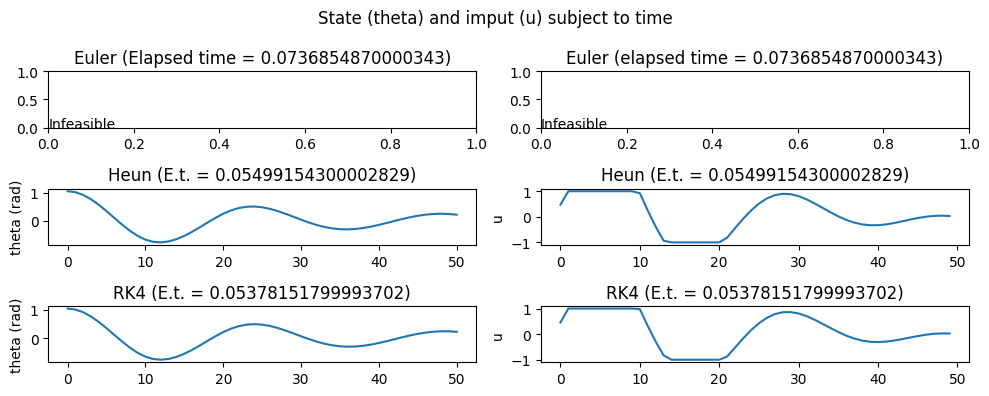

In [9]:
import time
import warnings
Time=np.zeros(3)

# Unit test.
L=1

"""
A_c=np.array([[2, 10],
              [0, 0]])
B_c=np.array([[0],
              [10]])
              """

A_c=np.array([[0, 1],
              [-9.81/L*np.sqrt(2)/2,0]])
B_c=np.array([[0],
              [1]])

Ts=0.1
#=========== Defining different ways for discretization of system =========
def euler(A_c,B_c,Ts):
  A_Euler=np.eye(A_c.shape[0])+A_c*Ts
  B_Euler=B_c*Ts
  return A_Euler,B_Euler

def heun(A_c,B_c,Ts):
  A_Heun=np.eye(A_c.shape[0])+A_c*Ts+A_c@A_c*Ts**2/2
  B_Heun=B_c*Ts+A_c@B_c*Ts**2/2
  return A_Heun,B_Heun

def rk4(A_c,B_c,Ts):
  A_RK4=np.eye(A_c.shape[0]) + A_c*Ts + A_c@A_c*Ts**2/2 + A_c@A_c@A_c*Ts**3/6 + A_c@A_c@A_c@A_c*Ts**4/24
  B_RK4=B_c*Ts + A_c@B_c*Ts**2/2 + A_c@A_c@B_c*Ts**3/6 + A_c@A_c@A_c@B_c*Ts**4/24
  return A_RK4,B_RK4

fig, ax = plt.subplots(3, 2, figsize=(10, 4))
ax=ax.flatten()
for i in range(3):


  Time[i] = time.perf_counter()
  if (i==0):
    A,B=euler(A_c,B_c,Ts)
  elif (i==1):
    A,B=heun(A_c,B_c,Ts)
  else:
    A,B=rk4(A_c,B_c,Ts)

#======== Defining data for problem definition ========
  Q = np.eye(2)
  R = np.array([[1]])
  P = Q
  N = 50
  xL = -15
  xU = 15
  uL = -1
  uU = 1
  x0 = np.array([np.pi/3,0])

  Af = np.array([[1, 0],
                 [0, 1],
                 [-1, 0],
                 [0, -1]])

  bf = np.ones((4, ))*2

  [feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af)
  if not feas:
    warnings.warn(f"Non-feasible for method {i}")


  Time[i] = time.perf_counter() - Time[i]
  print('time =', Time[i])
  print('feas =', feas)
  print('JOpt =', JOpt)
  print('xOpt =\n', xOpt)
  if feas:
    ax[2*i].plot(xOpt[0].T)
    ax[2*i].set_ylabel('theta (rad)')
    ax[2*i+1].plot(uOpt.T)
    ax[2*i+1].set_ylabel('u')
  else:
    ax[2*i].text(0,0,"Infeasible")
    ax[2*i+1].text(0,0,"Infeasible")


  if (i==0):

    ax[2*i].set_title(f"Euler (Elapsed time = {Time[i]})")
    ax[2*i+1].set_title(f"Euler (elapsed time = {Time[i]})")

    xOptEuler=xOpt
    uOptEuler=uOpt
    JOptEuler=JOpt
    feasEuler=feas
  elif (i==1):
    ax[2*i].set_title(f"Heun (E.t. = {Time[i]})")
    ax[2*i+1].set_title(f"Heun (E.t. = {Time[i]})")
    xOptHeun=xOpt
    uOptHeun=uOpt
    JOptHeun=JOpt
    feasHeun=feas
  else:
    ax[2*i].set_title(f"RK4 (E.t. = {Time[i]})")
    ax[2*i+1].set_title(f"RK4 (E.t. = {Time[i]})")
    xOptRK4=xOpt
    uOptRK4=uOpt
    JOptRK4=JOpt
    feasRK4=feas

plt.suptitle("State (theta) and imput (u) subject to time")
plt.tight_layout()
plt.show()

***

In [10]:
from scipy.integrate import solve_ivp

#===== Solving ODE numerically to compare with our discretization methods====
def solve_ode_nonlinear(x0, u, t_f,L):
  # Write your code here
  t0=0
  gravity=9.81
  def ode(t,x,gravity,L,u):
    theta, thetadot = x
    return [thetadot,-gravity/L*np.sin(theta)+u]
  sol=solve_ivp(fun=ode,t_span=[t0,t_f],y0=x0,rtol=1e-7,method='RK45',args=(gravity, L,u))
  time=sol.t

  x=sol.y

  return time,x





def solve_ode_linear(x0, u, t_f,L,A_c,B_c):
  # Write your code here
  t0=0
  gravity=9.81
  def linear_ode(t,x,A_c,B_c,u):
    theta, thetadot = x
    return A_c@([theta-np.pi/4,thetadot-0])+(B_c*u).flatten()
  sol=solve_ivp(fun=linear_ode, t_span=np.array([t0,t_f]), y0=x0, rtol=1e-7, method='RK45', args=(A_c,B_c,u))
  time=sol.t
  x=sol.y
  return time, x

/tmp/ipython-input-300/794584499.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


<function matplotlib.pyplot.show(close=None, block=None)>

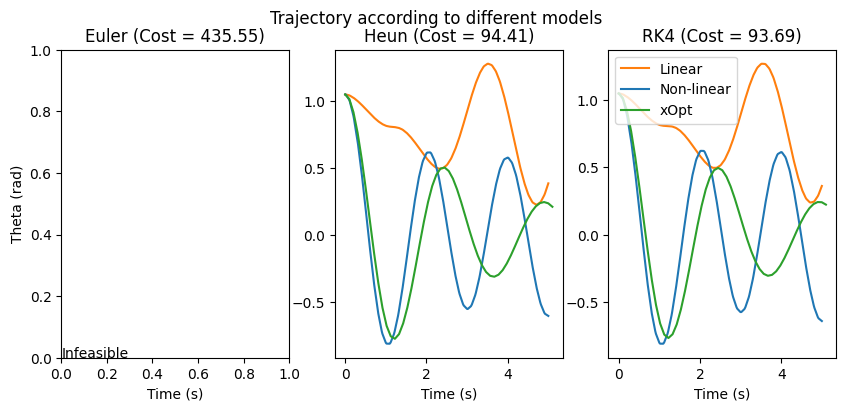

In [11]:
#====== Plotting different methods to check results =======

fig, ax = plt.subplots(1,3, figsize=(10, 4))

ax[0].set_title(f'Euler (Cost = {JOptEuler:.2f})')
ax[1].set_title(f'Heun (Cost = {JOptHeun:.2f})')
ax[2].set_title(f'RK4 (Cost = {JOptRK4:.2f})')


for model in range(3):
  if (model==0):
    uOpt=uOptEuler
    xOpt=xOptEuler
    feas=feasEuler
  elif (model==1):
    uOpt=uOptHeun
    xOpt=xOptHeun
    feas=feasHeun
  else :
    uOpt=uOptRK4
    xOpt=xOptRK4
    feas=feasRK4
  t_l=[]
  x_l=[]
  t_nl=[]
  x_nl=[]
  xs=[np.pi/4,0]
  x0_l=x0
  x0_nl=x0

  t_l = []
  x_l = []

  t_offset = 0.0


  for i in range(N):
    [ti_l, xi_l] = solve_ode_linear(x0_l, uOpt[0][i], Ts, L, A_c, B_c)

    # shift local time by current offset
    ti_l_global = ti_l + t_offset

    # update offset for next interval
    t_offset = ti_l_global[-1]

    t_l.append(ti_l_global)
    x_l.append(xi_l)

    # last state of this interval becomes initial condition for next
    x0_l = xi_l[:, -1]

    t_nl = []
  x_nl = []
  x0_nl = x0
  t_offset_nl = 0.0

  for i in range(N):
    ti_nl, xi_nl = solve_ode_nonlinear(x0_nl, uOpt[0][i], Ts, L)

    ti_nl_global = ti_nl + t_offset_nl
    t_offset_nl = ti_nl_global[-1]

    t_nl.append(ti_nl_global)
    x_nl.append(xi_nl)

    x0_nl = xi_nl[:, -1]

  t_nl=np.concatenate(t_nl)
  x_nl=np.concatenate(x_nl, axis=1)
  t_l=np.concatenate(t_l)
  x_l=np.concatenate(x_l,axis=1)




  if model==0:
    ax[model].set_ylabel("Theta (rad)")
  ax[model].set_xlabel("Time (s)")

  if feas:
    ax[model].plot(t_l.T,x_l[0].T,label="Linear",color="tab:orange")
    ax[model].plot(t_nl,x_nl[0].T,label="Non-linear",color="tab:blue")
    ax[model].plot(np.linspace(0,(N+1)*Ts,N+1),xOpt[0].T,label="xOpt",color="tab:green")
    plt.legend(loc="upper left")


  else:
    ax[model].text(0,0,"Infeasible")




"""
plt.plot(t_nl,x_nl[0].T,label="Non-linear")
plt.plot(t_l.T,x_l[0].T,label="Linear")
plt.plot(xOpt[0].T,xOpt[1].T,label="xOpt")


"""
plt.suptitle("Trajectory according to different models")
plt.show

